<a href="https://colab.research.google.com/github/Danysan1/ai-unibo-nlp-project/blob/main/a2/execution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2 execution

In [1]:
%pip install pandas numpy matplotlib transformers==4.25.1  dataset tensorflow_addons

Note: you may need to restart the kernel to use updated packages.


## Data loading

### Dataset download

In [2]:
import os
import urllib.request
from tqdm import tqdm

class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)
        
def download_url(url, output_path):
    with DownloadProgressBar(unit='B', unit_scale=True,
                             miniters=1, desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(url, filename=output_path, reporthook=t.update_to)

def download_data(data_path, url_path, suffix):    
    if not os.path.exists(data_path):
        os.makedirs(data_path)
        
    data_path = os.path.join(data_path, f'{suffix}.json')
    if not os.path.exists(data_path):
        print(f"Downloading CoQA {suffix} data split... (it may take a while)")
        download_url(url=url_path, output_path=data_path)
        print("Download completed!")

In [3]:
data_folder = 'Dataset'

In [4]:
# Train & Validation data
train_url = "https://nlp.stanford.edu/data/coqa/coqa-train-v1.0.json"
download_data(data_path=data_folder, url_path=train_url, suffix='train')

# Test data
test_url = "https://nlp.stanford.edu/data/coqa/coqa-dev-v1.0.json"
download_data(data_path=data_folder, url_path=test_url, suffix='test')

### Dataset loading

In [5]:
import numpy as np
import pandas as pd
import json
from os import path
from matplotlib import pyplot as plt

In [6]:
def loadDataset(filename):
    with open(path.join(data_folder, filename)) as file_obj:
        df = json.load(file_obj)["data"]
    print(f'{len(df)} stories / {len(df[0]["questions"])} questions in the first row')

    storyDType = pd.CategoricalDtype(pd.unique([story["story"] for story in df]))
    print(f"{storyDType.categories.size} distinct stories")

    sourceDType = pd.CategoricalDtype(pd.unique([story["source"] for story in df]))
    print(f"{sourceDType.categories.size} distinct sources: {sourceDType.categories}")

    df = np.array([
        [
            sourceDType.categories.get_loc(story["source"]), # Sources factorization
            storyDType.categories.get_loc(story["story"]), # Sources factorization
            story["questions"][question_index]["input_text"],
            story["answers"][question_index]["input_text"],
            story["answers"][question_index]["span_text"],
        ]
        for story in df
        for question_index in range(len(story["questions"]))
        if story["answers"][question_index]["input_text"] != 'unknown'
    ])
    print(f'{df.shape} question-answer pairs x columns')
    print(f'First row: {df[0]}')
    
    # https://marcobonzanini.com/2021/09/15/tips-for-saving-memory-with-pandas/
    # https://pandas.pydata.org/docs/user_guide/categorical.html
    df = pd.DataFrame({
        "source": pd.Series(pd.Categorical.from_codes(df[:,0].astype(np.int16), dtype=sourceDType)),
        "p": pd.Series(pd.Categorical.from_codes(df[:,1].astype(np.int16), dtype=storyDType)),
        "q": df[:,2],
        "a": df[:,3],
        "span": df[:,4],
    })

    return df

In [7]:
train_df = loadDataset("train.json")
train_df.count()

7199 stories / 20 questions in the first row
6605 distinct stories
5 distinct sources: Index(['wikipedia', 'cnn', 'gutenberg', 'race', 'mctest'], dtype='object')
(107276, 5) question-answer pairs x columns
First row: ['0' '0' 'When was the Vat formally opened?'
 'It was formally established in 1475' 'Formally established in 1475']


source    107276
p         107276
q         107276
a         107276
span      107276
dtype: int64

In [8]:
pd.unique(train_df["p"]).size

6605

In [9]:
pd.unique(train_df["span"]).size

99470

In [10]:
pd.unique(train_df["source"]).size

5

In [11]:
train_df.head()

,source,p,q,a,span
0,wikipedia,"The Vatican Apostolic Library (), more commonl...",When was the Vat formally opened?,It was formally established in 1475,Formally established in 1475
1,wikipedia,"The Vatican Apostolic Library (), more commonl...",what is the library for?,research,he Vatican Library is a research library
2,wikipedia,"The Vatican Apostolic Library (), more commonl...",for what subjects?,"history, and law",Vatican Library is a research library for hist...
3,wikipedia,"The Vatican Apostolic Library (), more commonl...",and?,"philosophy, science and theology",Vatican Library is a research library for hist...
4,wikipedia,"The Vatican Apostolic Library (), more commonl...",what was started in 2014?,a project,"March 2014, the Vatican Library began an initi..."


In [12]:
train_df.memory_usage(deep=True)

Index          128
source      107764
p         14241201
q          9110271
a          7714559
span      12090637
dtype: int64

In [13]:
#test_df = loadDataset("test.json")
#test_df.count()

## Data Pre-Processing

### Check unanswerable questions in the Train Dataset

In [14]:
idx = (train_df.a == 'unknown')
unanswerable = train_df[idx]
unanswerable.q.count()

0

All unanswerable questions in the Train Dataset have been already removed.

## Exploratory Data Analysis

In [15]:
train_df["p"][42]

'CHAPTER VII. THE DAUGHTER OF WITHERSTEEN \n\n"Lassiter, will you be my rider?" Jane had asked him. \n\n"I reckon so," he had replied. \n\nFew as the words were, Jane knew how infinitely much they implied. She wanted him to take charge of her cattle and horse and ranges, and save them if that were possible. Yet, though she could not have spoken aloud all she meant, she was perfectly honest with herself. Whatever the price to be paid, she must keep Lassiter close to her; she must shield from him the man who had led Milly Erne to Cottonwoods. In her fear she so controlled her mind that she did not whisper this Mormon\'s name to her own soul, she did not even think it. Besides, beyond this thing she regarded as a sacred obligation thrust upon her, was the need of a helper, of a friend, of a champion in this critical time. If she could rule this gun-man, as Venters had called him, if she could even keep him from shedding blood, what strategy to play his flame and his presence against the g

In [16]:
train_df["q"][42]

'Was Lassiter impressed with the horse?'

In [17]:
train_df["a"][42]

'Yes'

In [18]:
train_df["span"][42]

'When Jerd led out this slender, beautifully built horse Lassiter suddenly became all eyes.'

In [19]:
train_df["source"][42]

'gutenberg'

### Distribution statistics

Sources:

<AxesSubplot:>

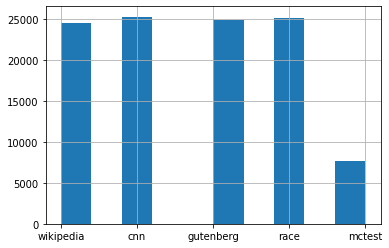

In [20]:
train_df["source"].hist()

Occurrences of 25 most popular stories:

<AxesSubplot:>

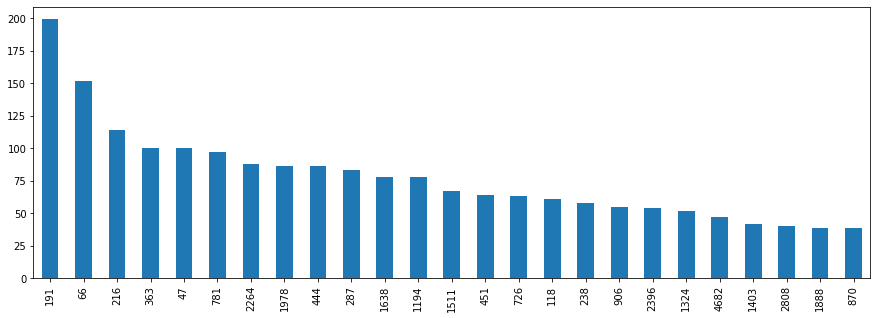

In [21]:
story_counts = train_df["p"].cat.codes.value_counts(sort=True)
story_counts[:25].plot(kind="bar", figsize=(15,5))

Occurrences of 25 least popular stories:

<AxesSubplot:>

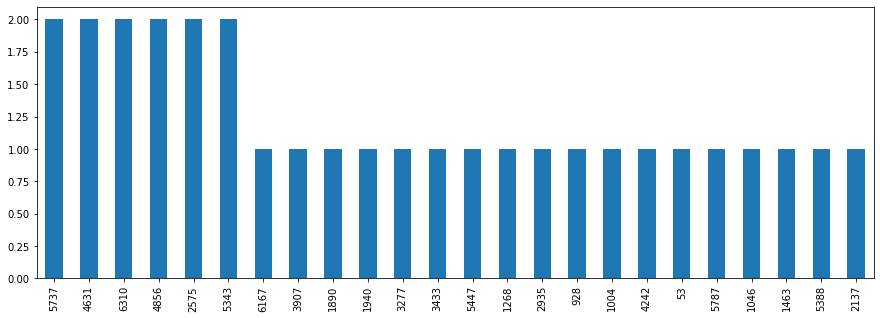

In [22]:
story_counts[-25:-1].plot(kind="bar", figsize=(15,5))

Histogram of story popularities:

<AxesSubplot:>

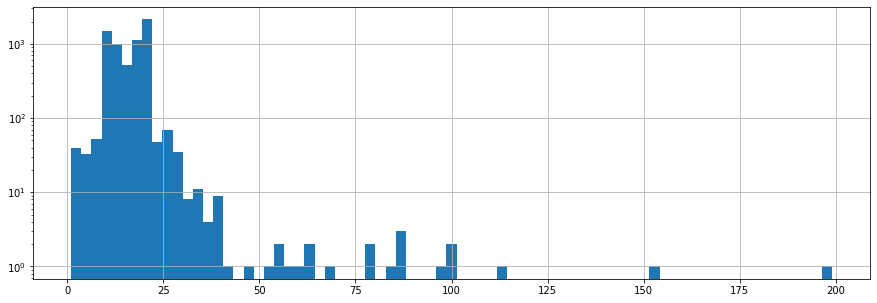

In [23]:
story_counts.hist(log=True,bins=75,figsize=(15,5))

### Removing rows with outlier story lengths to save memory

In [24]:
train_df.count()

source    107276
p         107276
q         107276
a         107276
span      107276
dtype: int64

LOGARITHMIC histogram of story length:

<AxesSubplot:>

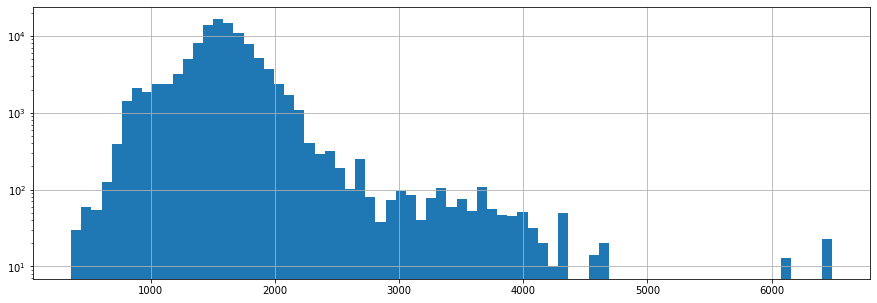

In [25]:
story_lengths = train_df["p"].str.len()
story_lengths.hist(log=True,bins=75,figsize=(15,5))

In [26]:
p_length_limit = story_lengths.quantile(0.999)
p_length_limit

4317.0

In [27]:
p_length_mask = story_lengths < p_length_limit
p_length_mask.value_counts()

True     107166
False       110
Name: p, dtype: int64

In [28]:
train_df = train_df[p_length_mask]
train_df.count()

source    107166
p         107166
q         107166
a         107166
span      107166
dtype: int64

### Removing rows with outlier question/answer/span lengths to save memory

LOGARITHMIC histogram of question length:

<AxesSubplot:>

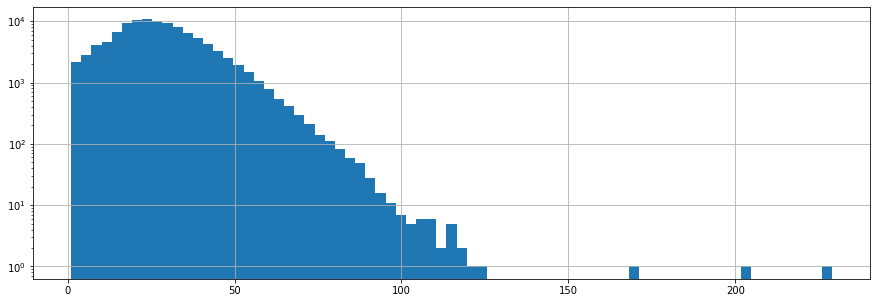

In [29]:
question_lengths = train_df["q"].str.len()
question_lengths.hist(log=True,bins=75,figsize=(15,5))

In [30]:
q_length_limit = question_lengths.quantile(0.999)
q_length_limit

89.0

LOGARITHMIC histogram of answer length:

<AxesSubplot:>

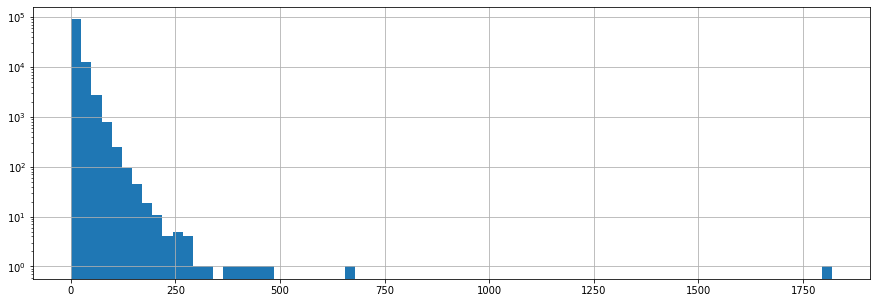

In [31]:
answer_lengths = train_df["a"].str.len()
answer_lengths.hist(log=True,bins=75,figsize=(15,5))

In [32]:
a_length_limit = answer_lengths.quantile(0.999)
a_length_limit

142.8350000000064

<AxesSubplot:>

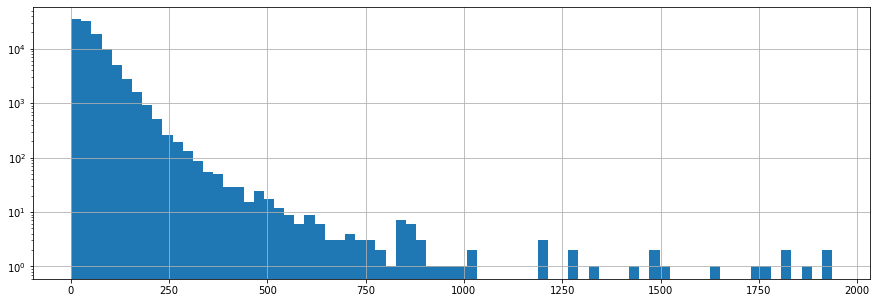

In [33]:
span_lengths = train_df["span"].str.len()
span_lengths.hist(log=True,bins=75,figsize=(15,5))

In [34]:
span_length_limit = span_lengths.quantile(0.999)
span_length_limit

502.5050000000192

In [35]:
bad_length_mask = (question_lengths > q_length_limit) | (answer_lengths > a_length_limit) | (span_lengths > span_length_limit)
bad_length_mask.value_counts()

False    106859
True        307
dtype: int64

In [36]:
excluded_stories = train_df["p"][bad_length_mask].unique()
len(excluded_stories)

272

In [37]:
excluded_mask = ~train_df["p"].isin(excluded_stories)
excluded_mask.value_counts()

True     102798
False      4368
Name: p, dtype: int64

In [38]:
train_df = train_df[excluded_mask]
train_df.count()

source    102798
p         102798
q         102798
a         102798
span      102798
dtype: int64

## Train-Validation-Test split

In [39]:
train_df = train_df.reset_index()

In [40]:
total_rows = len(train_df)
total_rows

102798

In [41]:
ideal_split_index = int(total_rows * 0.8)
ideal_split_index

82238

In [42]:
train_df[ ideal_split_index-3 : ideal_split_index+1 ]

,index,source,p,q,a,span
82235,85698,gutenberg,CHAPTER XVIII \n\nI \n\nTHOUGH he saw them twi...,Is she an adult?,yes,She had become secretary to Mr. Gruensberg of ...
82236,85699,gutenberg,CHAPTER XVIII \n\nI \n\nTHOUGH he saw them twi...,Who does she work for?,Gruensberg Leather Company,She had become secretary to Mr. Gruensberg of ...
82237,85700,gutenberg,CHAPTER XVIII \n\nI \n\nTHOUGH he saw them twi...,Who is her boss?,Mr. Gruensberg,She had become secretary to Mr. Gruensberg
82238,85701,gutenberg,CHAPTER XVIII \n\nI \n\nTHOUGH he saw them twi...,What is her job?,secretary,She had become secretary to Mr. Gruensberg


In [43]:
before_split_mask = pd.Series(np.linspace(0, total_rows, total_rows)) < ideal_split_index
before_split_mask.value_counts()

True     82238
False    20560
dtype: int64

In [44]:
split_story = train_df["p"][ideal_split_index - 1]
split_story_mask = train_df["p"] == split_story
split_story_mask.value_counts()

False    102780
True         18
Name: p, dtype: int64

In [45]:
train_mask = before_split_mask | split_story_mask
train_mask.value_counts()

True     82240
False    20558
dtype: int64

In [46]:
val_df = train_df[~train_mask]
train_df = train_df[train_mask]
len(val_df)

20558

## Model definition

### Utilities

In [47]:
from sklearn.metrics import f1_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from typing import List, Dict, Callable
import random

In [48]:
def predict_data(model: keras.Model,
                x: np.ndarray,
                prediction_info: Dict):
    """
    Inference routine of a given input set of examples

    :param model: Keras built and possibly trained model
    :param x: input set of examples in np.ndarray format
    :param prediction_info: dictionary storing model predict() argument information

    :return
        predictions: predicted labels in np.ndarray format
    """
    print(f'Starting prediction: \n{prediction_info}')
    print(f'Predicting on {x.shape[0]} samples')
    predictions = model.predict(x, **prediction_info)
    return predictions

In [49]:
def compute_f1(model: keras.Model, 
             x: np.ndarray, 
             y: np.ndarray):
    """
    Compute F1_score on the given data with corresponding labels

    :param model: Keras built and possibly trained model
    :param x: data in np.ndarray format
    :param y: ground-truth labels in np.ndarray format

    :return
        score: f1_macro_score
    """
    #predictions on the x set
    prediction_info = {
        'batch_size': 64,
        'verbose': 1
    }
    y_pred = predict_data(model=model, x=x, prediction_info=prediction_info)

    #compute argmax to take the best class for each sample
    y_pred = np.argmax(y_pred, axis=1)
    #compute the f1_macro
    score = f1_score(y, y_pred, average ='macro')
    return score

In [50]:
def set_reproducibility(seed):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [51]:
import tensorflow as tf
import tensorflow_addons as tfa
from tqdm import tqdm
from transformers import TFAutoModel, AutoTokenizer

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

### Question generation $f_\theta(P, Q)$ with text passage $P$ and question $Q$

### Seq2Seq LSTM

In [52]:
class MyTrainer(object):
    """
    Simple wrapper class

    train_op -> uses tf.GradientTape to compute the loss
    batch_fit -> receives a batch and performs forward-backward passes (gradient included)
    """

    def __init__(self, encoder, decoder, max_length):
        self.encoder = encoder
        self.decoder = decoder
        self.max_length = max_length
        self.ce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=1e-03)

    @tf.function
    def compute_loss(self, logits, target):
        loss = self.ce(y_true=target, y_pred=logits)
        mask = tf.logical_not(tf.math.equal(target, 0))
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_mean(loss)

    @tf.function
    def train_op(self, inputs):
        with tf.GradientTape() as tape:
            encoder_output, encoder_h, encoder_s = self.encoder({'input_ids': inputs['encoder_input_ids'],
                                                                 'hidden_state': inputs['encoder_state']})

            decoder_input = inputs['decoder_target'][:, :-1]  # ignore <end>
            real_target = inputs['decoder_target'][:, 1:]  # ignore <start>

            decoder.attention.setup_memory(encoder_output)

            decoder_initial_state = self.decoder.build_initial_state(decoder.batch_size, [encoder_h, encoder_s])
            predicted = self.decoder({'input_ids': decoder_input,
                                      'initial_state': decoder_initial_state}).rnn_output

            loss = self.compute_loss(logits=predicted, target=real_target)

        grads = tape.gradient(loss, self.encoder.trainable_variables + self.decoder.trainable_variables)
        return loss, grads

    @tf.function
    def batch_fit(self, inputs):
        loss, grads = self.train_op(inputs=inputs)
        self.optimizer.apply_gradients(zip(grads, self.encoder.trainable_variables + self.decoder.trainable_variables))
        return loss

    @tf.function
    def generate(self, input_ids):
        batch_size = input_ids.shape[0]
        encoder_initial_state = [tf.zeros((batch_size, self.encoder.encoder_units)),
                                 tf.zeros((batch_size, self.encoder.encoder_units))]
        encoder_output, encoder_h, encoder_s = self.encoder({
            'input_ids': input_ids,
            'hidden_state': encoder_initial_state
        })

        start_tokens = tf.fill([batch_size], tokenizer.word_index['<start>'])
        end_token = tokenizer.word_index['<end>']

        greedy_sampler = tfa.seq2seq.GreedyEmbeddingSampler()
        decoder_instance = tfa.seq2seq.BasicDecoder(cell=self.decoder.wrapped_decoder_cell,
                                                    sampler=greedy_sampler,
                                                    output_layer=self.decoder.generation_dense,
                                                    maximum_iterations=self.max_length)
        self.decoder.attention.setup_memory(encoder_output)

        decoder_initial_state = self.decoder.build_initial_state(batch_size, [encoder_h, encoder_s])
        decoder_embedding_matrix = self.decoder.embedding.variables[0]
        outputs, _, _ = decoder_instance(decoder_embedding_matrix,
                                         start_tokens=start_tokens,
                                         end_token=end_token,
                                         initial_state=decoder_initial_state)
        return outputs

    def translate(self, generated):
        return tokenizer.sequences_to_texts(generated.sample_id.numpy())


class Encoder(tf.keras.Model):

    def __init__(self, vocab_size, embedding_dim, encoder_units):
        super(Encoder, self).__init__()

        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.encoder_units = encoder_units

        self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size,
                                                   output_dim=embedding_dim)
        self.encoder_lstm = tf.keras.layers.LSTM(self.encoder_units,
                                                 return_sequences=True,
                                                 return_state=True)

    def call(self, inputs, training=False, **kwargs):
        input_ids = inputs['input_ids']
        input_emb = self.embedding(input_ids)
        encoder_output, lstm_hidden, lstm_states = self.encoder_lstm(input_emb, initial_state=inputs['hidden_state'])
        return encoder_output, lstm_hidden, lstm_states

    def initialize(self, batch_size):
        return [tf.zeros((batch_size, self.encoder_units)), tf.zeros((batch_size, self.encoder_units))]


class Decoder(tf.keras.Model):

    def __init__(self, vocab_size, max_sequence_length, embedding_dim, decoder_units, batch_size):
        super(Decoder, self).__init__()

        self.max_sequence_length = max_sequence_length
        self.batch_size = batch_size

        self.decoder_units = decoder_units
        self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size,
                                                   output_dim=embedding_dim)
        self.decoder_lstm_cell = tf.keras.layers.LSTMCell(self.decoder_units)

        self.attention = tfa.seq2seq.BahdanauAttention(units=self.decoder_units,
                                                       memory=None,
                                                       memory_sequence_length=self.batch_size * [max_sequence_length])

        self.wrapped_decoder_cell = tfa.seq2seq.AttentionWrapper(self.decoder_lstm_cell,
                                                                 self.attention,
                                                                 attention_layer_size=self.decoder_units)

        self.generation_dense = tf.keras.layers.Dense(vocab_size)
        self.sampler = tfa.seq2seq.sampler.TrainingSampler()
        self.decoder = tfa.seq2seq.BasicDecoder(self.wrapped_decoder_cell,
                                                sampler=self.sampler,
                                                output_layer=self.generation_dense)

    def build_initial_state(self, batch_size, encoder_state):
        initial_state = self.wrapped_decoder_cell.get_initial_state(batch_size=batch_size, dtype=tf.float32)
        initial_state = initial_state.clone(cell_state=encoder_state)
        return initial_state

    def call(self, inputs, training=False, **kwargs):
        input_ids = inputs['input_ids']
        input_emb = self.embedding(input_ids)
        decoder_output, _, _ = self.decoder(input_emb,
                                            initial_state=inputs['initial_state'],
                                            sequence_length=self.batch_size * [self.max_sequence_length - 1])
        return decoder_output

In [53]:
# Sample
input_sample = [
    "hello there how is it going",
    "this assignment is hellish"
]
output_sample = [
    "<start> it is going well <end>",
    "<start> I agree <end>"
]

batch_size = len(input_sample)

tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', oov_token='<UNK>')
tokenizer.fit_on_texts(input_sample + output_sample)

vocab_size = len(tokenizer.word_index) + 1

encoded_input_sample = tokenizer.texts_to_sequences(input_sample)
max_input_length = max([len(item) for item in encoded_input_sample])

encoded_output_sample = tokenizer.texts_to_sequences(output_sample)
max_output_length = max([len(item) for item in encoded_output_sample])

max_sequence_length = max(max_input_length, max_output_length)

encoded_input_sample = tf.keras.preprocessing.sequence.pad_sequences(encoded_input_sample,
                                                                        padding='post',
                                                                        maxlen=max_sequence_length)
encoded_output_sample = tf.keras.preprocessing.sequence.pad_sequences(encoded_output_sample,
                                                                        padding='post',
                                                                        maxlen=max_sequence_length)

# Test encoder
encoder = Encoder(vocab_size=vocab_size,
                    embedding_dim=50,
                    encoder_units=16)

sample_hidden = encoder.initialize(batch_size=batch_size)
encoder_sample_batch = {
    'input_ids': tf.convert_to_tensor(encoded_input_sample, dtype=tf.int32),
    'hidden_state': sample_hidden
}

sample_output, sample_h, sample_c = encoder(inputs=encoder_sample_batch)
print(f'{sample_output.shape} -- {sample_h.shape} -- {sample_c.shape}')

# Test decoder
decoder = Decoder(vocab_size=vocab_size,
                    embedding_dim=50,
                    decoder_units=16,
                    batch_size=batch_size,
                    max_sequence_length=max_sequence_length)
decoder.attention.setup_memory(sample_output)
initial_state = decoder.build_initial_state(batch_size, [sample_h, sample_c])

decoder_sample_batch = {
    'input_ids': tf.convert_to_tensor(encoded_output_sample, tf.int32),
    'initial_state': initial_state
}
sample_decoder_outputs = decoder(decoder_sample_batch).rnn_output
print(f'{sample_decoder_outputs.shape}')

(2, 6, 16) -- (2, 16) -- (2, 16)
(2, 5, 16)


In [54]:
# Training
trainer = MyTrainer(encoder=encoder,
                    decoder=decoder,
                    max_length=max_sequence_length)

In [55]:
epochs = 100
for epoch in tqdm(range(epochs)):
    encoder_hidden_state = encoder.initialize(batch_size=batch_size)
    batch = {
        'encoder_input_ids': encoded_input_sample,
        'encoder_state': encoder_hidden_state,
        'decoder_target': encoded_output_sample
    }
    loss = trainer.batch_fit(batch)
    print(f'Loss - {loss}')

    generated = trainer.generate(input_ids=encoded_input_sample)
    translated = trainer.translate(generated)
    print(f'Translated - {translated}')

  0%|          | 0/100 [00:00<?, ?it/s]

Loss - 2.220155715942383


  5%|▌         | 5/100 [00:10<02:27,  1.55s/it]

Translated - ['agree is going is going <end>', 'hello hello hello hello hello hello']
Loss - 2.2144815921783447
Translated - ['is is going going well well', 'agree well well well well well']
Loss - 2.208871364593506
Translated - ['is is going well well well', 'agree well well well well well']
Loss - 2.203260898590088
Translated - ['is is going well well well', 'agree agree well well well well']
Loss - 2.1975815296173096
Translated - ['is is going well well well', 'agree agree well well well well']
Loss - 2.191772222518921
Translated - ['is is going well well well', 'agree <end> well well well well']
Loss - 2.1857800483703613
Translated - ['well well well well well well', 'agree <end> <end> well well well']
Loss - 2.1795573234558105
Translated - ['well well well well well well', 'agree <end> <end> well well <end>']
Loss - 2.1730587482452393


 14%|█▍        | 14/100 [00:10<00:32,  2.69it/s]

Translated - ['well well well well well well', 'agree <end> <end> <end> well <end>']
Loss - 2.1662395000457764
Translated - ['well well well well well well', 'agree <end> <end> <end> well <end>']
Loss - 2.15905499458313
Translated - ['well well well well well well', 'agree <end> <end> <end> <end> well']
Loss - 2.151458263397217
Translated - ['well well well well well well', 'agree <end> <end> <end> <end> <end>']
Loss - 2.143401622772217
Translated - ['well well well well well well', 'agree <end> <end> <end> <end> <end>']
Loss - 2.1348342895507812
Translated - ['well well well well well well', 'agree <end> <end> <end> <end> <end>']
Loss - 2.125701904296875
Translated - ['well well well well well well', 'agree <end> <end> <end> <end> <end>']
Loss - 2.1159465312957764
Translated - ['well well well well well well', 'agree <end> <end> <end> <end> <end>']
Loss - 2.105506181716919
Translated - ['well well well well well well', 'agree <end> <end> <end> <end> <end>']


 24%|██▍       | 24/100 [00:10<00:11,  6.57it/s]

Loss - 2.0943121910095215
Translated - ['well well well well well well', 'agree <end> <end> <end> <end> <end>']
Loss - 2.0822911262512207
Translated - ['well well well well well well', 'agree <end> <end> <end> <end> <end>']
Loss - 2.0693631172180176
Translated - ['well well well well well well', 'agree <end> <end> <end> <end> <end>']
Loss - 2.0554404258728027
Translated - ['well well well well well well', 'agree <end> <end> <end> <end> <end>']
Loss - 2.0404295921325684
Translated - ['well well well well well well', 'agree <end> <end> <end> <end> <end>']
Loss - 2.024230480194092
Translated - ['well well well well well well', 'agree <end> <end> <end> <end> <end>']
Loss - 2.0067362785339355
Translated - ['well well well well well well', 'agree <end> <end> <end> <end> <end>']
Loss - 1.9878374338150024
Translated - ['well well well well well well', 'agree <end> <end> <end> <end> <end>']
Loss - 1.9674221277236938
Translated - ['well well well well well well', 'agree <end> <end> <end> <end> <

 34%|███▍      | 34/100 [00:11<00:05, 12.50it/s]

Loss - 1.9453814029693604
Translated - ['well well well well well well', 'agree <end> <end> <end> <end> <end>']
Loss - 1.9216142892837524
Translated - ['well well well well well well', 'agree <end> <end> <end> <end> <end>']
Loss - 1.8960365056991577
Translated - ['well well well well well well', 'agree <end> <end> <end> <end> <end>']
Loss - 1.8685919046401978
Translated - ['well well well well well well', 'agree <end> <end> <end> <end> <end>']
Loss - 1.8392646312713623
Translated - ['well well well well well well', 'agree <end> <end> <end> <end> <end>']
Loss - 1.8080971240997314
Translated - ['well well well well well well', 'agree <end> <end> <end> <end> <end>']
Loss - 1.775205373764038
Translated - ['well well well well well <end>', 'agree <end> <end> <end> <end> <end>']
Loss - 1.740796685218811
Translated - ['it well well well well <end>', 'agree <end> <end> <end> <end> <end>']
Loss - 1.7051769495010376


 44%|████▍     | 44/100 [00:11<00:02, 20.47it/s]

Translated - ['it well well well well <end>', 'agree <end> <end> <end> <end> <end>']
Loss - 1.6687523126602173
Translated - ['it well well well <end>', 'agree <end> <end> <end> <end>']
Loss - 1.6320117712020874
Translated - ['it well well well <end>', 'agree <end> <end> <end> <end>']
Loss - 1.5954949855804443
Translated - ['it <end>', 'agree <end>']
Loss - 1.5597426891326904
Translated - ['it <end>', 'agree <end>']
Loss - 1.5252338647842407
Translated - ['it <end>', 'agree <end>']
Loss - 1.4923290014266968
Translated - ['it <end>', 'agree <end>']
Loss - 1.4612271785736084
Translated - ['it <end>', 'agree <end>']
Loss - 1.431951880455017
Translated - ['it <end>', 'agree <end>']
Loss - 1.4043571949005127
Translated - ['it <end>', 'agree <end>']


 54%|█████▍    | 54/100 [00:11<00:01, 29.18it/s]

Loss - 1.3781652450561523
Translated - ['agree <end>', 'agree <end>']
Loss - 1.353021264076233
Translated - ['agree <end>', 'agree <end>']
Loss - 1.3285577297210693
Translated - ['agree <end>', 'agree <end>']
Loss - 1.3044493198394775
Translated - ['agree <end>', 'agree <end>']
Loss - 1.280451774597168
Translated - ['agree <end>', 'agree <end>']
Loss - 1.2564260959625244
Translated - ['agree <end>', 'agree <end>']
Loss - 1.2323439121246338
Translated - ['agree <end>', 'agree <end>']
Loss - 1.208270788192749
Translated - ['agree <end> <end>', 'agree agree <end>']
Loss - 1.1843342781066895
Translated - ['agree <end> <end>', 'agree agree <end>']
Loss - 1.1606756448745728
Translated - ['agree <end> <end>', 'agree agree <end>']


 64%|██████▍   | 64/100 [00:11<00:01, 35.87it/s]

Loss - 1.1373993158340454
Translated - ['agree is <end>', 'agree agree <end>']
Loss - 1.1145389080047607
Translated - ['agree is <end>', 'agree agree <end>']
Loss - 1.0920475721359253
Translated - ['agree is <end>', 'agree agree <end>']
Loss - 1.069818139076233
Translated - ['agree is <end>', 'agree agree <end>']
Loss - 1.0477182865142822
Translated - ['agree is <end>', 'agree agree <end>']
Loss - 1.0256311893463135
Translated - ['it is is <end>', 'agree agree <end> <end>']
Loss - 1.003488540649414
Translated - ['it is is <end>', 'agree agree <end> <end>']
Loss - 0.9812868237495422
Translated - ['it is is <end>', 'agree agree <end> <end>']
Loss - 0.9590826034545898
Translated - ['it is is <end>', 'agree agree <end> <end>']
Loss - 0.936976432800293
Translated - ['it is is well <end>', 'agree agree <end> <end> <end>']


 69%|██████▉   | 69/100 [00:11<00:00, 38.07it/s]

Loss - 0.9150853157043457
Translated - ['it is is well <end>', 'agree agree <end> <end> <end>']
Loss - 0.8935174942016602
Translated - ['it is is well <end>', 'agree agree <end> <end> <end>']
Loss - 0.8723518252372742
Translated - ['it is is well <end>', 'agree agree <end> <end> <end>']
Loss - 0.8516286611557007
Translated - ['it is is <end>', 'agree agree <end> <end>']
Loss - 0.831351101398468
Translated - ['it is is <end>', 'agree agree <end> <end>']
Loss - 0.8114961385726929
Translated - ['it is is <end>', 'agree agree <end> <end>']
Loss - 0.792035698890686
Translated - ['it is is <end>', 'agree agree <end> <end>']
Loss - 0.7729558944702148
Translated - ['it is is <end>', 'agree agree <end> <end>']
Loss - 0.7542745471000671
Translated - ['it is is <end>', 'agree agree <end> <end>']
Loss - 0.736041247844696


 79%|███████▉  | 79/100 [00:12<00:00, 41.22it/s]

Translated - ['it is is well <end>', 'agree agree <end> <end> <end>']
Loss - 0.7183204889297485
Translated - ['it is is well <end>', 'agree agree <end> <end> <end>']
Loss - 0.7011578679084778
Translated - ['it is is well <end>', 'agree agree <end> <end> <end>']
Loss - 0.6845463514328003
Translated - ['it is is well <end>', 'agree agree <end> <end> <end>']
Loss - 0.6684153079986572
Translated - ['it is is well <end>', 'agree agree <end> <end> <end>']
Loss - 0.6526552438735962
Translated - ['it is is well <end>', 'agree agree <end> <end> <end>']
Loss - 0.6371706128120422
Translated - ['it is is well <end>', 'agree agree <end> <end> <end>']
Loss - 0.6219223737716675
Translated - ['it is is well <end>', 'agree agree <end> <end> <end>']
Loss - 0.6069365739822388
Translated - ['it is going well <end>', 'agree agree <end> <end> <end>']


 89%|████████▉ | 89/100 [00:12<00:00, 40.86it/s]

Loss - 0.5922739505767822
Translated - ['it is going well <end>', 'agree agree <end> <end> <end>']
Loss - 0.577989399433136
Translated - ['it is going well <end>', 'agree agree <end> <end> <end>']
Loss - 0.564110279083252
Translated - ['it is going well <end>', 'i agree <end> <end> <end>']
Loss - 0.5506466031074524
Translated - ['it is going well <end>', 'i agree <end> <end> <end>']
Loss - 0.5376087427139282
Translated - ['it is going well <end>', 'i agree <end> <end> <end>']
Loss - 0.5250113606452942
Translated - ['it is going well <end>', 'i agree <end> <end> <end>']
Loss - 0.5128495097160339
Translated - ['it is going well <end>', 'i agree <end> <end> <end>']
Loss - 0.5010802745819092
Translated - ['it is going well <end>', 'i agree <end> <end> <end>']
Loss - 0.489637553691864


 99%|█████████▉| 99/100 [00:12<00:00, 40.46it/s]

Translated - ['it is going well <end>', 'i agree <end> <end> <end>']
Loss - 0.47847262024879456
Translated - ['it is going well <end>', 'i agree <end> <end> <end>']
Loss - 0.4675752520561218
Translated - ['it is going well <end>', 'i agree <end> <end> <end>']
Loss - 0.4569552540779114
Translated - ['it is going well <end>', 'i agree <end> <end> <end>']
Loss - 0.4466119706630707
Translated - ['it is going well <end>', 'i agree <end> <end> <end>']
Loss - 0.4365282952785492
Translated - ['it is going well <end>', 'i agree <end> <end> <end>']
Loss - 0.4266854226589203
Translated - ['it is going well <end>', 'i agree <end> <end> <end>']
Loss - 0.41707736253738403
Translated - ['it is going well <end>', 'i agree <end> <end> <end>']
Loss - 0.4077049791812897
Translated - ['it is going well <end>', 'i agree <end> <end> <end>']


100%|██████████| 100/100 [00:12<00:00,  7.96it/s]

Loss - 0.39856186509132385
Translated - ['it is going well <end>', 'i agree <end> <end> <end>']


In [56]:
#TODO

### Seq2Seq Bert-Tiny

In [57]:
class MyTrainer(object):
    """
    Simple wrapper class

    train_op -> uses tf.GradientTape to compute the loss
    batch_fit -> receives a batch and performs forward-backward passes (gradient included)
    """

    def __init__(self, encoder, decoder, max_length):
        self.encoder = encoder
        self.decoder = decoder
        self.max_length = max_length
        self.ce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=1e-03)

    @tf.function
    def compute_loss(self, logits, target):
        loss = self.ce(y_true=target, y_pred=logits)
        mask = tf.logical_not(tf.math.equal(target, 0))
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_mean(loss)

    @tf.function
    def train_op(self, inputs):
        with tf.GradientTape() as tape:
            encoder_output, encoder_h, encoder_s = self.encoder({'input_ids': inputs['encoder_input_ids'],
                                                                 'attention_mask': inputs['encoder_attention_mask']})

            decoder_input = inputs['decoder_target'][:, :-1]  # ignore <end>
            real_target = inputs['decoder_target'][:, 1:]  # ignore <start>

            decoder.attention.setup_memory(encoder_output)

            decoder_initial_state = self.decoder.build_initial_state(decoder.batch_size, [encoder_h, encoder_s])
            predicted = self.decoder({'input_ids': decoder_input,
                                      'initial_state': decoder_initial_state}).rnn_output

            loss = self.compute_loss(logits=predicted, target=real_target)

        grads = tape.gradient(loss, self.encoder.trainable_variables + self.decoder.trainable_variables)
        return loss, grads

    @tf.function
    def batch_fit(self, inputs):
        loss, grads = self.train_op(inputs=inputs)
        self.optimizer.apply_gradients(zip(grads, self.encoder.trainable_variables + self.decoder.trainable_variables))
        return loss

    # @tf.function
    def generate(self, input_ids, attention_mask=None):
        batch_size = input_ids.shape[0]
        encoder_output, encoder_h, encoder_s = self.encoder({
            'input_ids': input_ids,
            'attention_mask': attention_mask
        })

        start_tokens = tf.fill([batch_size], output_tokenizer.word_index['<start>'])
        end_token = output_tokenizer.word_index['<end>']

        greedy_sampler = tfa.seq2seq.GreedyEmbeddingSampler()
        decoder_instance = tfa.seq2seq.BasicDecoder(cell=self.decoder.wrapped_decoder_cell,
                                                    sampler=greedy_sampler,
                                                    output_layer=self.decoder.generation_dense,
                                                    maximum_iterations=self.max_length)
        self.decoder.attention.setup_memory(encoder_output)

        decoder_initial_state = self.decoder.build_initial_state(batch_size, [encoder_h, encoder_s])
        decoder_embedding_matrix = self.decoder.embedding.variables[0]
        outputs, _, _ = decoder_instance(decoder_embedding_matrix,
                                         start_tokens=start_tokens,
                                         end_token=end_token,
                                         initial_state=decoder_initial_state)
        return outputs

    def translate(self, generated):
        return output_tokenizer.sequences_to_texts(generated.sample_id.numpy())


class Encoder(tf.keras.Model):

    def __init__(self, model_name, decoder_units):
        super(Encoder, self).__init__()
        self.model = TFAutoModel.from_pretrained(model_name, from_pt=True)
        self.reducer = tf.keras.layers.Dense(decoder_units)

    def call(self, inputs, training=False, **kwargs):
        model_output = self.model(inputs)
        all_outputs = model_output[0]
        pooled_output = model_output[1]
        pooled_output = self.reducer(pooled_output)
        return all_outputs, pooled_output, pooled_output


class Decoder(tf.keras.Model):

    def __init__(self, vocab_size, max_sequence_length, embedding_dim, decoder_units, batch_size):
        super(Decoder, self).__init__()

        self.max_sequence_length = max_sequence_length
        self.batch_size = batch_size

        self.decoder_units = decoder_units
        self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size,
                                                   output_dim=embedding_dim)
        self.decoder_lstm_cell = tf.keras.layers.LSTMCell(self.decoder_units)

        self.attention = tfa.seq2seq.BahdanauAttention(units=self.decoder_units,
                                                       memory=None,
                                                       memory_sequence_length=self.batch_size * [max_sequence_length])

        self.wrapped_decoder_cell = tfa.seq2seq.AttentionWrapper(self.decoder_lstm_cell,
                                                                 self.attention,
                                                                 attention_layer_size=self.decoder_units)

        self.generation_dense = tf.keras.layers.Dense(vocab_size)
        self.sampler = tfa.seq2seq.sampler.TrainingSampler()
        self.decoder = tfa.seq2seq.BasicDecoder(self.wrapped_decoder_cell,
                                                sampler=self.sampler,
                                                output_layer=self.generation_dense)

    def build_initial_state(self, batch_size, encoder_state):
        initial_state = self.wrapped_decoder_cell.get_initial_state(batch_size=batch_size, dtype=tf.float32)
        initial_state = initial_state.clone(cell_state=encoder_state)
        return initial_state

    def call(self, inputs, training=False, **kwargs):
        input_ids = inputs['input_ids']
        input_emb = self.embedding(input_ids)
        decoder_output, _, _ = self.decoder(input_emb,
                                            initial_state=inputs['initial_state'],
                                            sequence_length=self.batch_size * [self.max_sequence_length - 1])
        return decoder_output


In [58]:
from transformers import BertForQuestionAnswering, AutoTokenizer, AutoConfig

model_name = 'prajjwal1/bert-tiny'

#config = AutoConfig.from_pretrained(model_name)
#model = BertForQuestionAnswering.from_pretrained(model_name, config=config)
input_tokenizer = AutoTokenizer.from_pretrained(model_name)

The next block of code is an example of encoding of a question-context pair: in this case, the question is the first part of the encoding, and the context is the second part. There are two special tokens: [CLS] token at the start of the encoding, [SEP] token between the question and the context, and at the end of the encoding.

In this case the context is the *span*, to provide a better example that explains the encoding.

In [59]:
line = 42

encoded_question = input_tokenizer(train_df['q'][line], return_tensors='tf', padding=True)
print(train_df['q'][line])

encoded_span = input_tokenizer(train_df['span'][line], return_tensors='tf', padding=True)
print(train_df['span'][line])

encoded_qs = input_tokenizer(train_df['q'][line], train_df['span'][line], return_tensors='tf', padding=True)

print('= '*40)
for idx, tok in zip(encoded_qs.input_ids.numpy()[0], input_tokenizer.convert_ids_to_tokens(encoded_qs.input_ids[0])):
    print("{}\t{}".format(idx, tok))

Was Lassiter impressed with the horse?
When Jerd led out this slender, beautifully built horse Lassiter suddenly became all eyes.
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
101	[CLS]
2001	was
27333	lass
21646	##iter
7622	impressed
2007	with
1996	the
3586	horse
1029	?
102	[SEP]
2043	when
15333	je
4103	##rd
2419	led
2041	out
2023	this
10944	slender
1010	,
17950	beautifully
2328	built
3586	horse
27333	lass
21646	##iter
3402	suddenly
2150	became
2035	all
2159	eyes
1012	.
102	[SEP]


Lets encode a part of the dataset in sentences of: [CLS] question [SEP] passage [SEP]. Otherwise, the training would be very slow.

In [60]:
max_length = 512  # The maximum length of a feature (question and context)
doc_stride = (
    128  # The authorized overlap between two part of the context when splitting
)
sentences = 20
sample = 10

In [61]:
# Input
qs = train_df['q'][range(sentences)] # questions
cs = train_df['p'][range(sentences)] # contexts

batch_size = len(qs)

encoded_inputs = input_tokenizer(
    qs.values.tolist(),
    cs.values.tolist(),
    #train_df['q'].values.tolist(),
    #train_df['p'].values.tolist(),
    truncation="only_second",
    max_length=max_length,
    stride=doc_stride,
    return_overflowing_tokens=True,
    return_offsets_mapping=True,
    padding="max_length",
    return_tensors='tf'
)

input_ids, attention_mask = encoded_inputs.input_ids, encoded_inputs.attention_mask
max_input_length = input_ids.shape[-1]

In [62]:
print("max_input_length:", max_input_length)
print("encoded_inputs shape =", encoded_inputs['input_ids'].shape)

max_input_length: 512
encoded_inputs shape = (20, 512)


The 'token_type_ids' encodes wether the encoded id is part of the question (=0) or the context (=1). The Attention Mask indicates if the input is needed (=1) or it's padding (=0).

Prepare also the expected outputs, for the training (this code follows the example given by the tutors, but I'm not convinced that this is the proper formatting for a QA Bert model).

In [63]:
# Output
outputs = "<start> " + train_df['a'][range(sentences)] + " <end>"

output_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', oov_token='<UNK>')
output_tokenizer.fit_on_texts(outputs)

output_vocab_size = len(output_tokenizer.word_index) + 1

encoded_output = output_tokenizer.texts_to_sequences(outputs)
print(encoded_output[sample])
max_output_length = max([len(item) for item in encoded_output])

[2, 30, 5, 31, 10, 5, 32, 33, 3]


In [64]:
max_sequence_length = max(max_input_length, max_output_length)

print("max_output_length: {}".format(max_output_length))
print("max_sequence_length: {}".format(max_sequence_length))

max_output_length: 11
max_sequence_length: 512


In [65]:
encoded_output = tf.keras.preprocessing.sequence.pad_sequences(encoded_output,
                                                                        padding='post',
                                                                        maxlen=max_sequence_length)
print(encoded_output[sample])

[ 2 30  5 31 10  5 32 33  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

In [66]:
# Test encoder
encoder = Encoder(model_name=model_name,
                    decoder_units=16)
encoder_output, encoder_h, encoder_s = encoder({'input_ids': input_ids,
                                                'attention_mask': attention_mask})
print(f'{encoder_output.shape} - {encoder_h.shape} - {encoder_s.shape}')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'bert.embeddings.position_ids', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the 

(20, 512, 128) - (20, 16) - (20, 16)


In [67]:
# Test decoder
decoder = Decoder(vocab_size=output_vocab_size,
                    embedding_dim=50,
                    decoder_units=16,
                    batch_size=batch_size,
                    max_sequence_length=max_sequence_length)
decoder.attention.setup_memory(encoder_output)
initial_state = decoder.build_initial_state(batch_size, [encoder_h, encoder_s])

decoder_batch = {
    'input_ids': tf.convert_to_tensor(encoded_output, tf.int32),
    'initial_state': initial_state
}
decoder_outputs = decoder(decoder_batch).rnn_output
print(f'{decoder_outputs.shape}')

(20, 511, 63)


In [68]:
# Training
trainer = MyTrainer(encoder=encoder,
                    decoder=decoder,
                    max_length=max_sequence_length)

In [69]:
epochs = 3
for epoch in tqdm(range(epochs)):
    batch = {
        'encoder_input_ids': input_ids,
        'encoder_attention_mask': attention_mask,
        'decoder_target': encoded_output
    }
    loss = trainer.batch_fit(batch)
    print(f'Loss - {loss}')

    generated = trainer.generate(input_ids=input_ids,
                                    attention_mask=attention_mask)
    translated = trainer.translate(generated)
    print(f'Translated - {translated}')

 33%|███▎      | 1/3 [00:08<00:16,  8.26s/it]

Loss - 0.03878410905599594
Translated - ['<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>']


 67%|██████▋   | 2/3 [00:09<00:04,  4.08s/it]

Loss - 0.03520103543996811
Translated - ['<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>']


100%|██████████| 3/3 [00:10<00:00,  3.52s/it]

Loss - 0.03424525633454323
Translated - ['<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>']


An example of answered question by the pretrained (*original*) model.

In [70]:
from transformers import TFBertForQuestionAnswering, pipeline

model = TFBertForQuestionAnswering.from_pretrained(model_name, from_pt=True)

question_answerer = pipeline("question-answering", model=model_name)

outputs = question_answerer(question=train_df['q'][0], context=train_df['p'][0])

print("model outputs:", outputs)
print()
print("official results are (from train.json):") 
print("span_start: 151")
print("span_end: 179")
print("span_text: Formally established in 1475")
print("input_text: It was formally established in 1475")
#print("start scores: {}".format(start_scores))
#print("end scores: {}".format(end_scores))

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForQuestionAnswering: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForQuestionAnswering from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForQuestionAnswering from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForQuestionAnswering were not initialized from the PyTorch model and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initial

model outputs: {'score': 3.4231896279379725e-05, 'start': 810, 'end': 849, 'answer': 'initial four-year project of digitising'}

official results are (from train.json):
span_start: 151
span_end: 179
span_text: Formally established in 1475
input_text: It was formally established in 1475


### BERT2BERT Bert-Tiny

In [71]:
#entire dataset
contexts = list(train_df['p'])
questions = list(train_df['q'])
answers = list(train_df['a'])

In [72]:
#take a subset from the training set
start = 0
end = 95000
contexts = list(train_df['p'])
questions = list(train_df['q'])
answers = list(train_df['a'])
contexts = contexts[start:end]
questions = questions[start:end]
answers = answers[start:end]
len(contexts)

82240

In [73]:
from transformers import EncoderDecoderModel, AutoTokenizer
from tqdm import tqdm


model_name = 'prajjwal1/bert-tiny'

# tie_encoder_decoder to share weights and half the number of parameters
model = EncoderDecoderModel.from_encoder_decoder_pretrained(model_name, model_name,
                                                                        #encoder_from_pt=True,
                                                                        #decoder_from_pt=True,
                                                                        tie_encoder_decoder=True)

tokenizer = AutoTokenizer.from_pretrained(model_name)

# set special tokens
model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.eos_token_id = tokenizer.sep_token_id
model.config.pad_token_id = tokenizer.pad_token_id

# set decoding params                               
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.repetition_penalty = 5.0
model.config.num_beams = 2
model.config.vocab_size = model.config.encoder.vocab_size


Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertLMHeadModel: ['cls.seq_re

In [74]:
encodings = tokenizer(questions, contexts, 
                          padding=True,
                          truncation= 'only_second',
                          max_length = 499,
                          )
input_ids, input_attention_mask = encodings['input_ids'], encodings['attention_mask']
label_values = tokenizer(answers,
                          padding=True,
                          truncation=True,
                          max_length = 25,
                          )
labels, labels_mask = label_values['input_ids'], label_values['attention_mask']



#Tokens with indices set to ``-100`` are ignored (masked) during training, the loss is only computed for the tokens with labels
masked_labels = [[-100 if token == tokenizer.pad_token_id else token for token in labels] for labels in labels]
print(f'length of input_ids: {np.shape(input_ids)}')

length of input_ids: (82240, 499)


In [75]:
encodings.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [76]:
encodings.pop('token_type_ids')
encodings.update({#'decoder_input_ids': labels,
                 #'decoder_attention_mask': labels_mask,
                 'labels': masked_labels
                 })
encodings.keys()

dict_keys(['input_ids', 'attention_mask', 'labels'])

In [77]:
import torch
from torch.utils.data import Dataset, DataLoader

class CustomTextDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

In [78]:
#parameters
batch_size = 16
num_epochs = 3
lr = 4e-4

In [79]:
from timeit import default_timer as timer
#create training dataset
train_dataset = CustomTextDataset(encodings)
#create training dataloader
train_ld = torch.utils.data.DataLoader(train_dataset,
                                     batch_size=batch_size,
                                     )

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
optim = torch.optim.AdamW(model.parameters(), lr=lr)
loop_start = timer()
for epoch in range(num_epochs):
    model.train()
    loss_score = []
    loop = tqdm(train_ld)
    for batch in loop:
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        loss, outputs = model(input_ids,
                              attention_mask=attention_mask,
                              labels = labels
                        )[:2]
        loss_score.append(loss.item())
        #loss = outputs[0]
        loss.backward()
        optim.step()

        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())
    average_loss = np.mean(loss_score)
    print(f"\nEpoch: {epoch}, average Loss: {average_loss}")
loop_end = timer()
time_loop = loop_end - loop_start
print(f'\nTime for {num_epochs} epochs (s): {(time_loop):.3f}')

  0%|          | 0/5140 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:634: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
Epoch 0: 100%|██████████| 5140/5140 [03:05<00:00, 27.70it/s, loss=3.06]



Epoch: 0, average Loss: 4.06643428584481


Epoch 1: 100%|██████████| 5140/5140 [03:04<00:00, 27.90it/s, loss=2.64]



Epoch: 1, average Loss: 3.3645927429663067


Epoch 2: 100%|██████████| 5140/5140 [03:04<00:00, 27.83it/s, loss=2.21]


Epoch: 2, average Loss: 3.071040308707419

Time for 3 epochs (s): 554.492


In [80]:
#Free some memory
import gc
del encodings,input_ids,input_attention_mask,labels
torch.cuda.empty_cache()
torch.cuda.reset_accumulated_memory_stats()
gc.collect()

23

#### Generation

Load test dataset.

In [81]:
test_df = loadDataset("test.json")
test_df.count()

500 stories / 12 questions in the first row
499 distinct stories
5 distinct sources: Index(['mctest', 'race', 'cnn', 'wikipedia', 'gutenberg'], dtype='object')
(7917, 5) question-answer pairs x columns
First row: ['0' '0' 'What color was Cotton?' 'white'
 'a little white kitten named Cotton']


source    7917
p         7917
q         7917
a         7917
span      7917
dtype: int64

In [82]:
context_test = list(test_df['p'])
question_test = list(test_df['q'])
answer_test = list(test_df['a'])

In [83]:
input_values = tokenizer(question_test,context_test, padding=True, truncation=True, max_length = 499)
input_ids, input_attention_mask = input_values['input_ids'], input_values['attention_mask']

In [84]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
l = []
model.to(device)
model.eval()
for input, mask in zip(input_ids,input_attention_mask):
  input = np.expand_dims(np.array(input), axis=0)
  mask = np.expand_dims(np.array(mask), axis=0)
  generated = model.generate(input_ids=torch.tensor(input).to(device),
                             #attention_mask=torch.tensor(mask).to(device), 
                                                 max_length=20,
                                                 repetition_penalty=5.,
                                                 min_length=1,
                                                 no_repeat_ngram_size=3,
                                                 early_stopping=True,
                                                decoder_start_token_id = model.config.decoder_start_token_id,
                                                 num_beams=2,
                                                 )
  generated = tokenizer.batch_decode(generated, skip_special_tokens=True)
  l.append(generated)

In [85]:
x = pd.DataFrame(l, columns = ['generated'])
x['questions'] = question_test
x['answers'] = answer_test
#pd.set_option('display.max_rows', None)
#x.head(300)

In [86]:
#utility functions taken from the allennlp library for computing the F1-score
import collections
import re
import string
from typing import Callable, Sequence, TypeVar, Tuple

def get_tokens(s):
    if not s:
        return []
    return normalize_answer(s).split()

def normalize_answer(s):
    """Lower text and remove punctuation, articles and extra whitespace."""

    def remove_articles(text):
        regex = re.compile(r"\b(a|an|the)\b", re.UNICODE)
        return re.sub(regex, " ", text)

    def white_space_fix(text):
        return " ".join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return "".join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))

def compute_f1(a_pred: str, a_gold: str) -> float:
    pred_toks = get_tokens(a_pred)
    gold_toks = get_tokens(a_gold)
    common = collections.Counter(pred_toks) & collections.Counter(gold_toks)  # type: ignore[var-annotated]
    num_same = sum(common.values())
    if len(pred_toks) == 0 or len(gold_toks) == 0:
        # If either is no-answer, then F1 is 1 if they agree, 0 otherwise
        return float(pred_toks == gold_toks)
    if num_same == 0:
        return 0.0
    precision = 1.0 * num_same / len(pred_toks)
    recall = 1.0 * num_same / len(gold_toks)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1

In [87]:
score = []
predictions = x['generated']
true_answers = x['answers']
for a_pred, a_gold in zip(predictions, true_answers):
  score.append(compute_f1(a_pred, a_gold))

average_score = np.mean(score)
print(f'average_score: {average_score}')
x['score'] = score
total = len(x[x['score'] != 0])
print(f'length: {total} / {len(x)}')


average_score: 0.15128731932084713
length: 1537 / 7917


In [88]:
pd.set_option('display.max_rows', None)
correct = x[x['score'] != 0]
correct = correct.reset_index(drop=True)
correct.head(100)

,generated,questions,answers,score
0,no,Did she live alone?,no,1.000000
1,her mom,Who did she live with?,with her mommy and 5 sisters,0.250000
2,no,Was Cotton happy that she looked different tha...,no,1.000000
3,no,Did they want Cotton to change the color of he...,no,1.000000
4,no,Did a little boy write the note,No,1.000000
5,a paper,What?,a paper carrier bag,0.500000
6,a piece of paper,What kind of dishes does she bring?,"hot soup and a container with rice, vegetables...",0.095238
7,no,Is he still alive?,No,1.000000
8,he was murdered.,What happened in the early 80's?,Farina was cast in a film,0.250000
9,he was a movie,What happened in 2004?,He joined a TV show cast.,0.250000


### BERT2BERT Distilroberta-base

In [89]:
#entire dataset
contexts = list(train_df['p'])
questions = list(train_df['q'])
answers = list(train_df['a'])

In [90]:
#take a subset from the training set
start = 0
end = 95000
contexts = list(train_df['p'])
questions = list(train_df['q'])
answers = list(train_df['a'])
contexts = contexts[start:end]
questions = questions[start:end]
answers = answers[start:end]
len(contexts)

82240

In [91]:
from transformers import EncoderDecoderModel, AutoTokenizer
from tqdm import tqdm


model_name = 'distilroberta-base'

# tie_encoder_decoder to share weights and half the number of parameters
model = EncoderDecoderModel.from_encoder_decoder_pretrained(model_name, model_name, tie_encoder_decoder=True)

tokenizer = AutoTokenizer.from_pretrained(model_name)

# set special tokens
model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.eos_token_id = tokenizer.sep_token_id
model.config.pad_token_id = tokenizer.pad_token_id

# set decoding params                               
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.repetition_penalty = 5.0
model.config.num_beams = 2
model.config.vocab_size = model.config.encoder.vocab_size


Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForCausalLM were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['roberta.encoder.layer.2.crossattention.self.value.bias', 'roberta.encoder.layer.4.crossattention.self.key.weight', 'roberta.encoder.layer.5.crossattention.out

In [ ]:
encodings = tokenizer(questions, contexts, 
                          padding=True,
                          truncation= True,
                          max_length = 512,
                          )
input_ids, input_attention_mask = encodings['input_ids'], encodings['attention_mask']
label_values = tokenizer(answers,
                          padding=True,
                          truncation=True,
                          max_length = 25,
                          )
labels, labels_mask = label_values['input_ids'], label_values['attention_mask']



#Tokens with indices set to ``-100`` are ignored (masked) during training, the loss is only computed for the tokens with labels
masked_labels = [[-100 if token == tokenizer.pad_token_id else token for token in labels] for labels in labels]
print(f'length of input_ids: {np.shape(input_ids)}')

In [ ]:
encodings.keys()

In [ ]:
encodings.update({'labels': masked_labels})
encodings.keys()

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class CreateDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

In [ ]:
#parameters
batch_size = 16
num_epochs = 3
#also try with lr = 4e-4
lr = 4e-5

In [ ]:
from timeit import default_timer as timer
#create training dataset
train_dataset = CreateDataset(encodings)
#create training dataloader
train_ld = torch.utils.data.DataLoader(train_dataset,
                                     batch_size=batch_size,
                                     )

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
optim = torch.optim.AdamW(model.parameters(), lr=lr)
loop_start = timer()
for epoch in range(num_epochs):
    model.train()
    loss_score = []
    loop = tqdm(train_ld)
    for batch in loop:
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        loss, outputs = model(input_ids,
                              attention_mask=attention_mask,
                              labels = labels
                        )[:2]
        loss_score.append(loss.item())
        loss.backward()
        optim.step()

        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())
    average_loss = np.mean(loss_score)
    print(f"Epoch: {epoch}, average Loss: {average_loss}")
loop_end = timer()
time_loop = loop_end - loop_start
print(f'\nTime for {num_epochs} epochs (s): {(time_loop):.3f}')

In [ ]:
#Free some memory
import gc
del encodings,input_ids,input_attention_mask,labels
torch.cuda.empty_cache()
torch.cuda.reset_accumulated_memory_stats()
gc.collect()

####Generation

Load test dataset.

In [ ]:
test_df = loadDataset("test.json")
test_df.count()

In [ ]:
context_test = list(test_df['p'])
question_test = list(test_df['q'])
answer_test = list(test_df['a'])

In [ ]:
input_values = tokenizer(question_test,context_test, padding=True, truncation=True, max_length = 512)
input_ids, input_attention_mask = input_values['input_ids'], input_values['attention_mask']

In [ ]:
#utility functions taken from the allennlp library for computing the F1-score
import collections
import re
import string
from typing import Callable, Sequence, TypeVar, Tuple

def get_tokens(s):
    if not s:
        return []
    return normalize_answer(s).split()

def normalize_answer(s):
    """Lower text and remove punctuation, articles and extra whitespace."""

    def remove_articles(text):
        regex = re.compile(r"\b(a|an|the)\b", re.UNICODE)
        return re.sub(regex, " ", text)

    def white_space_fix(text):
        return " ".join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return "".join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))

def compute_f1(a_pred: str, a_gold: str) -> float:
    pred_toks = get_tokens(a_pred)
    gold_toks = get_tokens(a_gold)
    common = collections.Counter(pred_toks) & collections.Counter(gold_toks)  # type: ignore[var-annotated]
    num_same = sum(common.values())
    if len(pred_toks) == 0 or len(gold_toks) == 0:
        # If either is no-answer, then F1 is 1 if they agree, 0 otherwise
        return float(pred_toks == gold_toks)
    if num_same == 0:
        return 0.0
    precision = 1.0 * num_same / len(pred_toks)
    recall = 1.0 * num_same / len(gold_toks)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
l = []
model.to(device)
#set the model in evaluation mode
model.eval()
for input, mask in zip(input_ids,input_attention_mask):
  input = np.expand_dims(np.array(input), axis=0)
  mask = np.expand_dims(np.array(mask), axis=0)
  generated = model.generate(input_ids=torch.tensor(input).to(device),
                                                 max_length=20,
                                                 repetition_penalty=5.,
                                                 min_length=1,
                                                 no_repeat_ngram_size=3,
                                                 early_stopping=True,
                                                decoder_start_token_id = model.config.decoder_start_token_id,
                                                 num_beams=2,
                                                 )
  generated = tokenizer.batch_decode(generated, skip_special_tokens=True)
  l.append(generated)

In [ ]:
x = pd.DataFrame(l, columns = ['generated'])
x['answers'] = answer_test
#pd.set_option('display.max_rows', None)
#x.head(300)

In [ ]:
score = []
predictions = x['generated']
true_answers = x['answers']
for a_pred, a_gold in zip(predictions, true_answers):
  score.append(compute_f1(a_pred, a_gold))
average_score = np.mean(score)
print(f'average_score: {average_score}')
x['score'] = score
total = len(x[x['score'] != 0])
print(f'length: {total} / {len(x)}')


In [ ]:
pd.set_option('display.max_rows', None)
correct = x[x['score'] != 0]
correct = correct.reset_index(drop=True)
correct.head(500)

### Question generation $f_\theta(P, Q, H)$ with text passage $P$, question $Q$ and dialogue history $H$

In [ ]:
# TODO

## Train and evaluate $f_\theta(P, Q)$ and $f_\theta(P, Q, H)$

In [ ]:
# TODO

## Conclusions

In [ ]:
# TODO